In [39]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

from crm import CrmpBHP
from crm.helpers.features import construct_real_production_rate_dataset, get_real_producer_data

plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 100

### Project Goals & Workflow

* Predict the oil production rate using Capacitance-Resistance Model - Producer (CRMP)
* CRMP implemented as a Scikit-Learn Estimator
    * Common API
    * Use different cross validation tools provided by Scikit-Learn to determine the optimal parameters for CRMP

### Capacitance-Resistance Model - Producer (CRMP)

![CRMP](./crmp.jpg)

CRM is a reservoir model that works with injection and production rates to predict future production in a waterflooded reservoir. It does this by using an electrical analogy:
* Current sources = Injection Rate
* Capacitors = Reservoir unit storage capacity
* Resistance = Inverse of fluid transmissiblity
* Final Current = Production Rate

<p><center>(Sayarpour et al., 2009)</center></p>

$$
q_{j}^{k} = q_{j}^{k-1} e^{\frac{-\Delta t}{\tau_{j}}} + (1 - e^{\frac{-\Delta t}{\tau_{j}}}) \sum_{i=1}^{I} f_{ij} I_{i}^{k} 
$$

Where:

- $ q_{j}^{k} $ = production rate at producer $j$ at time step $k$ (bbls/day)

- $ \Delta t $ = time that elapses during time step $k$ (day)

- $ \tau_{j} $ = time constant (days)

- $ f_{ij} $ = gains (dimensionless)

- $ I_{i}^{k} $ = injection rate at injection $i$ at time step $k$

### Reading in the Data

Below we are using the Pandas library to read in our data from the file titled `real_data.csv`.

In [40]:
producers_df = pd.read_csv('producer_data.csv')
producers_df

,Name,Date,Oil Vol,Gas Vol,Water Vol,On-Line,Av BHP,Spot BHP,Av BHT,Av WHP,total rate,Total Vol
0,PA01,2006-01-18,10137.969883,3.649669,0.000000,24.0,1306.895533,1306.895533,71.043468,11.706617,10137.969883,10137.969883
1,PA01,2006-01-19,10284.588362,3.702452,0.000000,24.0,1300.320709,1300.320709,71.030729,11.660105,10284.588362,10284.588362
2,PA01,2006-01-20,10166.182575,3.659826,0.000000,24.0,1295.713656,1295.713656,71.038178,11.672988,10166.182575,10166.182575
3,PA01,2006-01-21,10761.568696,3.874165,0.000000,24.0,1270.421282,1270.421282,70.996767,13.114115,10761.568696,10761.568696
4,PA01,2006-01-22,10066.976951,3.624112,0.000000,24.0,1276.963023,1276.963023,71.011942,14.287374,10066.976951,10066.976951
...,...,...,...,...,...,...,...,...,...,...,...,...
5043,PA12,2008-09-26,11460.847550,4.584339,316.819237,24.0,1604.838509,0.000000,69.380000,25.008438,11777.666786,11777.666786
5044,PA12,2008-09-27,10097.258972,4.038904,456.999387,24.0,1599.325880,0.000000,69.390000,24.928578,10554.258359,10554.258359
5045,PA12,2008-09-28,11303.818145,4.521527,1300.796200,24.0,1592.922426,0.000000,69.390000,24.781634,12604.614345,12604.614345
5046,PA12,2008-09-29,11731.832956,4.692733,415.436619,24.0,1586.437549,0.000000,69.390000,24.676091,12147.269576,12147.269576


In [41]:
injectors_df = pd.read_csv('injector_data.csv')
injectors_df

,Name,Date,Water Vol,On-Line,Av BHP,Spot BHP,Av BHT,Av WHP,Cum WHP,Cum Volume
0,IA04,2006-01-18 00:00:00,2750.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,2750.00000
1,IA04,2006-01-19 00:00:00,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,2750.00000
2,IA04,2006-01-20 00:00:00,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,2750.00000
3,IA04,2006-01-21 00:00:00,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,2750.00000
4,IA04,2006-01-22 00:00:00,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,2750.00000
...,...,...,...,...,...,...,...,...,...,...
1994,IA13,2008-09-26 00:00:00,0.0,0.0,777.418526,0.0,0.0,57.45402,5389.797504,903913.48028
1995,IA13,2008-09-27 00:00:00,0.0,0.0,789.545271,0.0,0.0,57.45402,5447.251524,903913.48028
1996,IA13,2008-09-28 00:00:00,0.0,0.0,776.432075,0.0,0.0,57.45402,5504.705544,903913.48028
1997,IA13,2008-09-29 00:00:00,0.0,0.0,653.364129,0.0,0.0,57.45402,5562.159563,903913.48028


The relavent columns for our model are time, producer data, and injector data. Here we will be working with the first producer.

As you can see in the dataframe above, not all of the producers have the same start date. In order to ensure that we are only working with the producer once it is active, there is a list with the starting indicies for each producer named `producer_starting_indicies`. We would normally have code that would find these indicies for us and would ensure we are starting at the right time for each well, but for the sake of example we will have it in a hardcoded list.

In [42]:
producer_starting_indicies = [0, 160, 279, 433, 821, 853, 1074]

name ='PA01'
injector_names = ['IA04', 'IA08', 'IA11', 'IA13']

producer = get_real_producer_data(producers_df, name, bhp=True)
injectors = injectors_df[['Name', 'Date', 'Water Vol']]
X, y = construct_real_production_rate_dataset(
    producer, injectors, injector_names
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.40, shuffle=False
)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

number_of_days = len(producer)
time = np.linspace(1, number_of_days, number_of_days)

Here we have a plot of the the production rate over time for the first producer.

Text(0.5, 1.0, 'Producer 1: Production Rate vs Time')

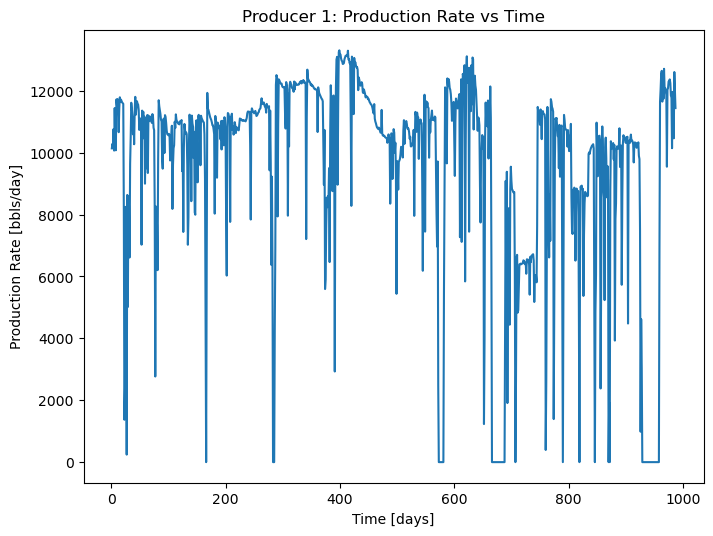

In [44]:
plt.plot(time, producer['PA01'])
plt.xlabel('Time [days]')
plt.ylabel('Production Rate [bbls/day]')
plt.title('Producer 1: Production Rate vs Time')

### Preparing the Data to be used by CRMP

We are now ready to put our data into a format where we can `fit` the parameters for our model and `predict` with the model.

The feature matrix, `X`, should have it's first column as the production rate and the following columns should be the injector rates. The production rate column in the `X` matrix should be from one time step behind the value you are trying to predict, `y` column, and the injection rates should be from the same time step you are trying to predict. For practical purposes this means that everything but the last production time should be in first column of `X`, and everything but the first time should be in the injection columns. The target vector, `y`, should be the production rate except for the first time.

Before we `predict` with the model, we must first `fit` it to ensure all the parameters have appropriate values for our data. The API for `CRMP` is based off of Scikit-Learn estimators since `CRMP` extends the `BaseEstimator` and `RegressorMixin`.

We have the option of passing in an initial guess to CRMP, but it is not required. If you do choose to pass in an initial guess, you must pass in a list whose length is equal to the number of injectors + 1. The first index in the list for the initial guess is `tau`, our time constant. All of the indicies after are the gains for the injectors. Please play around with the initial guesses if you would like.

Printed below are the fitted parameter values for the model.

In [45]:
crmp = CrmpBHP().fit(X_train, y_train)
print('Tau: ', crmp.tau_)
print('Gains: ', crmp.gains_)

Tau:  88.2310753828867
Gains:  [3.09945167e-01 6.90054833e-01 0.00000000e+00 1.14521877e-16]


We can now use the model to predict since we have finished fitting the model. We predict with the `predict` function. The only paramter you need to pass in is the `X_test` matrix. The output is the predicted production values.

In [46]:
y_hat = crmp.predict(X_test[:,1:])

Below we have a plot of the actual testing values and the predicted values. The areas of the plot that are purple indicate an overlap or very similar values in prediction and actual. The overlap in prediction and actual are substantial, which shows us that CRMP is a good model for secondary recovery with water flooding.

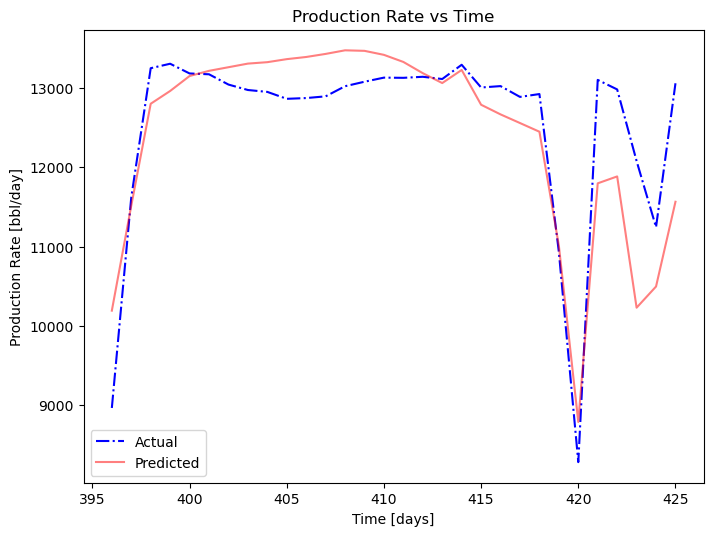

In [47]:
test_time = time[len(X_train) + 1:]

plt.plot(test_time[:30], y_test[:30], '-.', c='b')
plt.plot(test_time[:30], y_hat[:30],  c='r', alpha=0.5)
plt.xlabel('Time [days]')
plt.ylabel('Production Rate [bbl/day]')
plt.title('Production Rate vs Time')
plt.legend(['Actual', 'Predicted'])

### Metrics
We are using mean squared error (MSE) as our metric to measure the quality of prediction.

In [38]:
print('MSE: ', mean_squared_error(y_hat, y_test))

MSE:  87137479.06228088


### Practice

Ok, now you have seen that example, it is time to use CRM on the other wells. Just like you would with any other Scikit-Learn estimator, you need to construct a feature matrix and a target vector.

### Future Work

* Make the code `pip install`-able
* Implement oil cut model (ex: Koval)
* Uncertainty model

### References

Bruce, W. A. "An electrical device for analyzing oil-reservoir behavior." Transactions of the AIME 151, no. 01 (1943): 112-124.

Chitsiripanich, Soros. "Field application of capacitance-resistance models to identify potential location for infill drilling." PhD diss., 2015.

Holanda, Rafael Wanderley de, Eduardo Gildin, Jerry L. Jensen, Larry W. Lake, and C. Shah Kabir. "A state-of-the-art literature review on capacitance resistance models for reservoir characterization and performance forecasting." Energies 11, no. 12 (2018): 3368.

Hyndman, Rob J., and George Athanasopoulos. Forecasting: principles and practice. OTexts, 2018.

Kim, Jong S., Larry W. Lake, and Thomas F. Edgar. "Integrated capacitance-resistance model for characterizing waterflooded reservoirs." IFAC Proceedings Volumes 45.8 (2012): 19-24.

Lee, Boum Hee. "Algorithm-aided decision-making in reservoir management." PhD diss., 2019.

Sayarpour, Morteza, Elizabeth Zuluaga, C. Shah Kabir, and Larry W. Lake. "The use of capacitance–resistance models for rapid estimation of waterflood performance and optimization." Journal of Petroleum Science and Engineering 69, no. 3-4 (2009): 227-238.

VanderPlas, Jake. Python data science handbook: Essential tools for working with data. " O'Reilly Media, Inc.", 2016.